In [ ]:
%pip install --quiet qiskit_optimization qiskit_optimization['cplex'] docplex matplotlib

# QUAC 609 - Class Project 1 - Smart Scheduler for EV Charging

To address the smart scheduling of EV charging in public parking spaces, we propose a Smart Charging Management System (SCMS) that optimizes the use of EVSE equipments while balancing electricity supply constraints and user preferences. This system would incorporate both classical and quantum computing approaches to solve the combinatorial optimization problem efficiently.

In [3]:
from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization import QuadraticProgram
import numpy as np
import matplotlib.pyplot as plt

## 1. Problem Data

In this problem, we define a scheduling framework for electric vehicle (EV) charging, where time is divided into 20 discrete time bins, each representing a 30-minute interval (i.e., a total scheduling horizon of 10 hours).

We consider 5 electric vehicles, each of which has:

- Unique arrival times, meaning each EV may enter the charging station at a different time bin.
- Varying charge requests, representing the amount of energy (in kWh) needed before departure.
-  Different departure times, specifying when an EV must leave the station, setting a constraint on its available charging slots.

This information is dynamically collected from a mobile application, allowing real-time updates on EV arrivals, requested charging levels, and departure times. This dynamic input ensures that the charging schedule adapts to actual user needs while optimizing energy distribution within grid constraints.

In [4]:
num_bins = 20                                   # Number of time bins
e = np.array([50, 10, 50, 50, 10])              # Energy requests in kWh
num_evs = len(e)                                # Number of charging spaces or outlets
V = 240                                         # Voltage in volts
dt = 0.5                                        # Time step duration in hours
max_power = 20                                  # Maximum power in kW
arr_times = np.array([1, 1, 4, 6, 7])           # Arrival time bins
dep_times = np.array([13, 10, 19, 20, 17])      # Departure time bins

## 2. Time-Based Charging Penalty Calculation

The function `calculate_time_penalty` is designed to compute a **time-based penalty matrix** for electric vehicle (EV) charging scheduling. The penalty incentivizes earlier charging by assigning higher values when the departure time is far away and lower values as the departure time approaches. This encourages a charging schedule that prioritizes earlier time slots, reducing the risk of unmet charging demands before an EV departs. 

$$
U^{QC}(\hat{r}) := \sum_{k=1}^{n} \frac{T-t_k}{T-t_1} \sum_{i \in v_{t_k}} r_i(t_k)
$$

The resulting matrix guides the optimization algorithm by incorporating a time-dependent priority in scheduling. By penalizing later charging, the system encourages vehicles to charge earlier within their available window, reducing grid congestion and ensuring timely fulfillment of charging needs.

In [13]:
def calculate_time_penalty(num_evs, num_bins, arr_times, dep_times):
    time_penalty = np.zeros((num_evs, num_bins))
    for i in range(num_evs):
        total_available_time = dep_times[i] - arr_times[i]
        for t in range(arr_times[i], dep_times[i]):
            remaining_time = dep_times[i] - t
            time_penalty[i, t] = remaining_time / total_available_time
            
    return time_penalty

## 3. Constraints

### 3.1 Power Constraint: 
This constraint ensures that the total charging current across all EVs at each time step does not exceed the maximum allowed power (max_power).

- The sum of the charging currents for all EVs at time t is multiplied by the voltage V (converted into kW by dividing by 1000).
- The result should be less than or equal to max_power at each time step.
- This prevents the grid or charging system from exceeding its power capacity at any given time.

### 3.2 Maximum Energy Constraint: 
- Each EV has a maximum energy requirement, which must not be exceeded by the total energy delivered during the charging period.
- The total delivered energy for each EV should be less than or equal to the required energy (e[i]) for that EV.
- This ensures that no EV is overcharged beyond its energy requirement.

### 3.3 Time Constraints for Each EV:

- Before Arrival: For each EV, the charging current is set to 0 for all time bins before the arrival time (arr_times[i]). This means the EV does not start charging until it arrives.
- After Departure: For each EV, the charging current is also set to 0 for all time bins after the departure time (dep_times[i]). This ensures that no charging occurs once the EV has departed.

These time constraints enforce that charging can only occur within the arrival and departure windows for each EV.

### 3.4 Maximum Charging Rate per EV: This constraint limits the charging current for each EV at each time step to a maximum of 64 amps.

This ensures that the charging rate does not exceed the system’s or each EV’s maximum charging capacity (64A is assumed to be the maximum in this case).

In [6]:
def add_constraints(mdl, num_evs, num_bins, V, max_power, e, arr_times, dep_times, charging_current, delivered_energy):
    # Power constraint
    mdl.add_constraints(mdl.sum(charging_current[i, t] for i in range(num_evs)) * V / 1000 <= max_power 
                        for t in range(num_bins))

    # Maximum energy constraint
    mdl.add_constraints(delivered_energy[i] <= e[i] for i in range(num_evs))

    # Time constraints for each EV
    for i in range(num_evs):
        mdl.add_constraints(charging_current[i, t] == 0 for t in range(arr_times[i]))
        mdl.add_constraints(charging_current[i, t] == 0 for t in range(dep_times[i], num_bins))

    # Maximum charging rate per EV (assuming 64A is the max)
    mdl.add_constraints(charging_current[i, t] <= 64 for i in range(num_evs) for t in range(num_bins))

## 4. EV Charging Optimization Model

###Decision Variables

The decision variable charging_current is created as a matrix, representing the charging current for each EV at each time step. The current is bounded between 0 and 64 amps.

For each EV, the total energy delivered during the scheduling period is computed. This is done by summing the charging current over all time bins and multiplying by the voltage and time duration. The result is converted into kWh.

The energy deviation is calculated for each EV as the difference between the delivered energy and the required energy. This helps in quantifying how much the charging deviates from the desired amount.

The objective function is the sum of the energy deviation and the fast charging penalty, with a weighting factor for the fast charging component. The optimization model aims to minimize this objective function. This can mathematically represented as:


$$
U^{NC}(\hat{r}) := -\sqrt[p]{\sum_{i \in v_{t_k}} |(\sum_{k=1}^{n} r_i(t_k) \cdot V \cdot \Delta t - e_i)|^p}
$$

In [7]:
def create_ev_charging_model(num_evs, num_bins, V, dt, max_power, e, arr_times, dep_times):
    # Initialize the model
    mdl = Model(name='EV Charging Schedule')

    # Decision variable: charging current for each EV at each time step
    charging_current = mdl.integer_var_matrix(num_evs, num_bins, lb=0, ub=64, name='charging_current')

    # Compute delivered energy for each EV in kWh
    delivered_energy = [mdl.sum(charging_current[i, t] for t in range(num_bins)) * V * dt / 1000 for i in range(num_evs)]

    # Compute energy deviation for each EV
    energy_deviation = [delivered_energy[i] - e[i] for i in range(num_evs)]

    # Calculate time penalty for fast charging incentive
    time_penalty = calculate_time_penalty(num_evs, num_bins, arr_times, dep_times)

    # Objective function components
    fast_charging = mdl.sum(charging_current[i, t] * time_penalty[i, t] for i in range(num_evs) for t in range(num_bins))
    energy_deviation_sum = mdl.sum_squares(energy_deviation[i] for i in range(num_evs))

    # Normalize objective components
    # max_fast_charging = 64 * num_evs * num_bins  # Maximum possible value for fast_charging
    # normalized_fast_charging = fast_charging / max_fast_charging
    # normalized_energy_deviation = energy_deviation_sum / num_evs

    # Combined objective function
    objective = energy_deviation_sum + 0.01 * fast_charging
    mdl.minimize(objective)

    # Add constraints
    add_constraints(mdl, num_evs, num_bins, V, max_power, e, arr_times, dep_times, charging_current, delivered_energy)

    return mdl, charging_current


## 5. Solving the Model

In [8]:
import time

model, charging_current = create_ev_charging_model(num_evs, num_bins, V, dt, max_power, e, arr_times, dep_times)

start_time = time.time()
model.solve()
end_time = time.time()
print(f"Solve time: {end_time - start_time} seconds")

optimized_schedule = np.array([[charging_current[i, t].solution_value for t in range(num_bins)] for i in range(num_evs)])

## 6. Plotting the Optimized Decision Variables

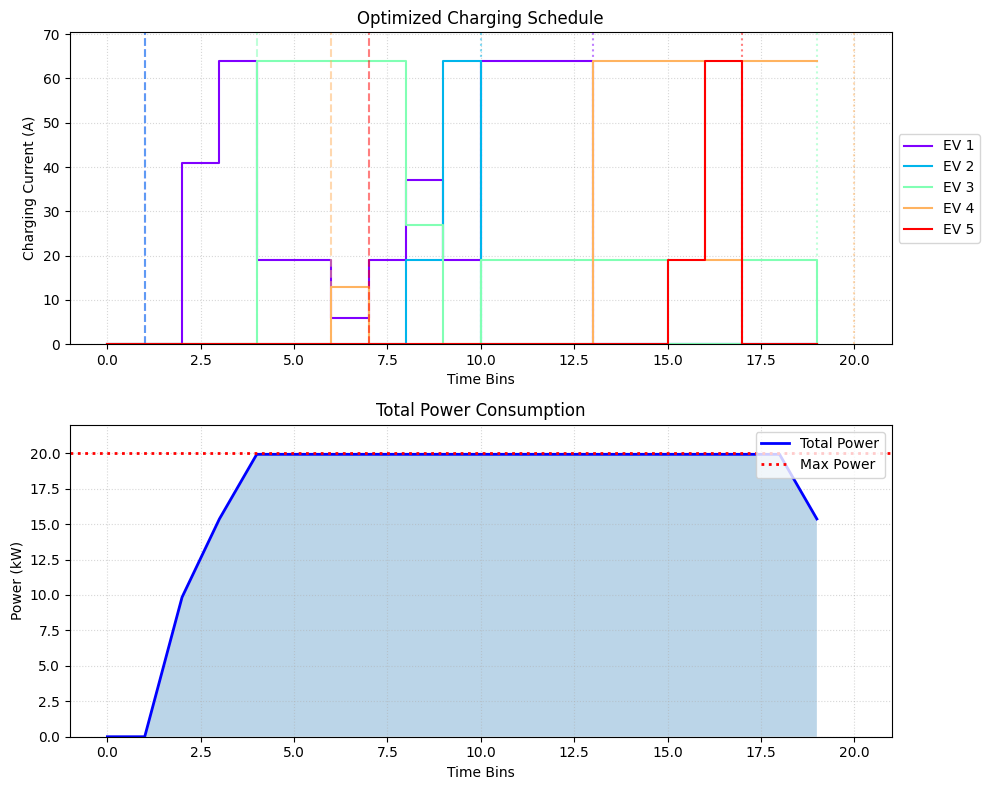

In [ ]:
def plot_charging_schedule(optimized_schedule, arr_times, dep_times, V, max_power, num_bins):
    num_evs = optimized_schedule.shape[0]
    
    plt.figure(figsize=(10, 8))
    
    # Charging schedule plot
    ax1 = plt.subplot(2, 1, 1)
    colors = plt.cm.rainbow(np.linspace(0, 1, num_evs))
    
    for i in range(num_evs):
        plt.step(range(num_bins), optimized_schedule[i], label=f'EV {i+1}', 
                 where='post', color=colors[i])
        plt.axvline(x=arr_times[i], color=colors[i], linestyle='--', alpha=0.5)
        plt.axvline(x=dep_times[i], color=colors[i], linestyle=':', alpha=0.5)

    plt.xlabel('Time Bins')
    plt.ylabel('Charging Current (A)')
    plt.title('Optimized Charging Schedule')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True, which='both', linestyle=':', alpha=0.5)
    
    # Adjust y-axis to show a bit above the maximum current
    plt.ylim(0, max(map(max, optimized_schedule)) * 1.1)

    # Total power consumption plot
    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    total_power = np.sum(optimized_schedule, axis=0) * V / 1000
    plt.plot(range(num_bins), total_power, 'b-', label='Total Power', linewidth=2)
    plt.axhline(y=max_power, color='r', linestyle=':', label='Max Power', linewidth=2)
    plt.fill_between(range(num_bins), total_power, alpha=0.3)
    
    plt.xlabel('Time Bins')
    plt.ylabel('Power (kW)')
    plt.title('Total Power Consumption')
    plt.legend(loc='upper right')
    plt.grid(True, which='both', linestyle=':', alpha=0.5)
    
    # Adjust y-axis to show a bit above the maximum power
    plt.ylim(0, max(max_power, max(total_power)) * 1.1)

    plt.tight_layout()
    plt.show()

plot_charging_schedule(optimized_schedule, arr_times, dep_times, V, max_power, num_bins)

## 7. Optimized Charging Schedule
The quantum algorithm generates a highly optimized charging schedule, which is then transmitted to the corresponding EV charging equipment. This schedule consists of a time series of charging instructions, precisely tailored for each individual charging station. The process works as follows:

- Data Generation - The quantum algorithm produces a detailed time series of charging data for each EV.
- Secure Transmission: This data is securely sent to the smart charging stations via encrypted channels.
- Charging Current Regulation - Each charging station interprets the received data to regulate its charging current dynamically.
- Real-time Adjustments - The system continuously monitors and adjusts the charging current based on the quantum-optimized schedule.

By following this optimized schedule, the overall grid stability is maintained while meeting individual EV charging needs and ensures that each EV receives the optimal amount of charge at the most efficient times, balancing individual needs with overall system capacity and grid stability.

In [ ]:
if optimized_schedule is not None:
    print("Optimized Charging Schedule (Amperes):")
    print(optimized_schedule)

    # Calculate delivered energy
    delivered_energy = np.sum(optimized_schedule, axis=1) * V * dt / 1000
    print("\nDelivered Energy (kWh):")
    print(delivered_energy)

    print("\nRequested Energy (kWh):")
    print(e)

    print(f"\nTotal Energy Delivered: {np.sum(delivered_energy):.2f} kWh")
    print(f"Maximum Power: {max_power} kW")

else:
    print("Optimization failed to find a solution.")

Optimized Charging Schedule (Amperes):
[[ 0.  0. 41. 64. 19. 19.  6. 19. 37. 19. 64. 64. 64.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 19. 64.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0. 64. 64. 64. 64. 27.  0. 19. 19. 19. 19. 19.  0.  0. 19.
  19.  0.]
 [ 0.  0.  0.  0.  0.  0. 13.  0.  0.  0.  0.  0.  0. 64. 64. 64. 19. 64.
  64. 64.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 19. 64.  0.
   0.  0.]]

Delivered Energy (kWh):
[49.92  9.96 49.92 49.92  9.96]

Requested Energy (kWh):
[50 10 50 50 10]

Total Energy Delivered: 169.68 kWh
Maximum Power: 20 kW


## 8. Analysing Metrics
Measure energy delivery accuracy, comparing the actual energy delivered to each EV against the requested amount. 

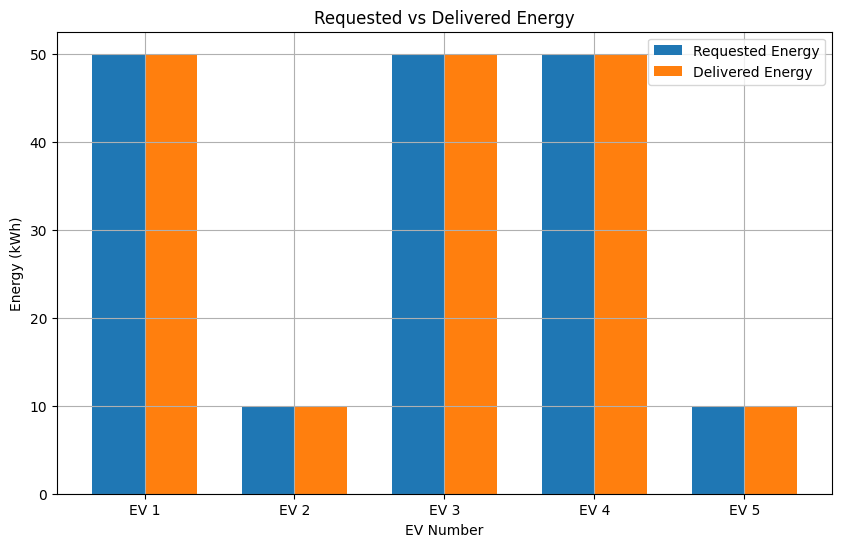

In [ ]:
# Energy delivery plot
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(num_evs)
plt.bar(index, e, bar_width, label='Requested Energy')
plt.bar(index + bar_width, delivered_energy, bar_width, label='Delivered Energy')
plt.xlabel('EV Number')
plt.ylabel('Energy (kWh)')
plt.title('Requested vs Delivered Energy')
plt.xticks(index + bar_width/2, [f'EV {i+1}' for i in range(num_evs)])
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
%pip install --quiet dwave-ocean-sdk seaborn matplotlib 

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dimod import BinaryQuadraticModel, SimulatedAnnealingSampler, BINARY
import seaborn as sns


In [ ]:
# Define the problem parameters
num_evs = 5  # Number of EVs
time_slots = 10  # Number of time slots
grid_capacity = 20  # Maximum power that can be withdrawn from the grid at any time
power_requested = [30, 40, 50, 10, 50]  # Power requested by each EV
arrival_times = [1, 2, 3, 4, 5]  # Arrival times of each EV
departure_times = [5, 6, 9, 8, 10]  # Departure times of each EV

In [ ]:

# Define problem parameters
num_evs = 3  # Number of EVs
time_slots = 10  # Number of time slots (each slot is 1 hour)
grid_capacity_kw = 50  # Maximum power withdrawable at any time (in kW)
power_requested_kwh = [30, 40, 50]  # Power requested by each EV (in kWh)
arrival_times = [1, 2, 3]  # Arrival times of each EV
departure_times = [5, 7, 9]  # Departure times of each EV

# Convert power requested from kWh to kW (assuming 1-hour time slots)
power_requested_kw = power_requested_kwh  # Since 1 kWh / 1 h = 1 kW

# Create a Binary Quadratic Model
bqm = BinaryQuadraticModel(BINARY)

# Objective function: Minimize total power withdrawn from the grid
for i in range(num_evs):
    for t in range(arrival_times[i], departure_times[i]):
        bqm.add_linear(f'x_{i}_{t}', power_requested_kw[i])

# Fast charging incentive: Prefer earlier charging
fast_charging_penalty = 1.0  # Small weight to encourage fast charging
for i in range(num_evs):
    for t in range(arrival_times[i], departure_times[i]):
        bqm.add_linear(f'x_{i}_{t}', -fast_charging_penalty)  # Negative penalty encourages early charging

# Constraint: Total power withdrawn should not exceed grid capacity
penalty_weight = 10.0  # Lagrange multiplier for constraint penalty
for t in range(time_slots):
    constraint_expr = []
    for i in range(num_evs):
        if arrival_times[i] <= t < departure_times[i]:
            constraint_expr.append((f'x_{i}_{t}', power_requested_kw[i]))

    if constraint_expr:  # Apply penalty only if there are charging EVs at time t
        bqm.add_linear_equality_constraint(
            [(var, coeff) for var, coeff in constraint_expr],
            lagrange_multiplier=penalty_weight,
            constant=-grid_capacity_kw
        )

# Solve the problem using simulated annealing
sampler = SimulatedAnnealingSampler()
response = sampler.sample(bqm, num_reads=100)

# Extract the best solution
best_solution = response.first.sample

# Create a charging schedule matrix (EVs x Time Slots)
charging_schedule = np.zeros((num_evs, time_slots))

# Populate schedule from the solution
for i in range(num_evs):
    for t in range(time_slots):
        if best_solution.get(f'x_{i}_{t}', 0) == 1:
            charging_schedule[i, t] = power_requested_kw[i]


# Calculate total power withdrawn from the grid at each time slot
total_power_withdrawn = np.sum(charging_schedule, axis=0)

# Plot 2: Total Power Withdrawn from Grid
plt.figure(figsize=(10, 5))
plt.bar(range(time_slots), total_power_withdrawn, color='royalblue', alpha=0.8)
plt.axhline(y=grid_capacity_kw, color='r', linestyle='--', label="Grid Capacity")
plt.xlabel("Time Slots")
plt.ylabel("Power Withdrawn (kW)")
plt.title("Total Power Withdrawn from Grid Over Time")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# Plot 3: Number of Time Slots Each EV is Charging
ev_charging_durations = np.sum(charging_schedule > 0, axis=1)

plt.figure(figsize=(7, 5))
plt.bar([f'EV {i}' for i in range(num_evs)], ev_charging_durations, color='cornflowerblue')
plt.xlabel("EVs")
plt.ylabel("Charging Time Slots")
plt.title("Number of Time Slots Each EV is Charging")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()